<h1><b> E-Challenge Machine Learning Edition 2021 <b><h1>

<h2> A Predictive Maintenance Workflow by <h2>

<h2> MARS <h2>

<ul> 

  <li> Ávila Carlos </li> 

  <li> Castro Marco </li> 

  <li> Delgado Jorge </li> 

</ul>

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import glob
import datetime as dt
import os
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import missingno as msno
plt.rcParams['agg.path.chunksize'] = 10000
import matplotlib.dates as mdates
import seaborn as sns
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import random
import zipfile

Mounted at /content/drive


# Functions

In [ ]:
# This function let us to load the data of train or test
def Load_Data(path):
    
    all_files = glob.glob(path + '/*.csv')
    
    t_dataset = []

    for file_name in all_files:
        if 'production' not in file_name:
            df = pd.read_csv(file_name, index_col=None, header=0, engine='python')
            t_dataset.append(df)

    df_data = pd.concat(t_dataset, axis=0, ignore_index=True)
    return df_data

In [ ]:
# This function let us to know the name and the amount of wells in the dataset
def Name_Amount(df):
  df.groupby('WELL_ID').size()
  name_wells = df['WELL_ID'].unique()
  print(len(name_wells))
  return name_wells



In [ ]:
# This funcion let us know the amount of every failure only in the train dataset
def Failure_Amount(df):
  manualoff_failure = df[(df['WellFailure']=='yes')]
  yes_failure = df[(df['WellFailure']=='Manual off')]
  print('the amount of "Manual off" failures is: ',len(manualoff_failure))
  print('the amount of "yes" failures is: ',len(yes_failure))
  total_failures = np.append(manualoff_failure['WELL_ID'], yes_failure['WELL_ID'])
  total_failures.sort()
  print('the total amount of failures in the dataset is: ', len(total_failures))

In [ ]:
# This function let us optimize the dataframe, will join columns with the same variable like 'PRESS_INT' with 'PRESS_INTK' and drop the last one
def Optimize_df(df):
    
    df['PRESS_INT'] = df['PRESS_INT'].fillna(df['PRESS_INTK'])
    df['TEMP_INT'] = df['TEMP_INT'].fillna(df['TEMP_INTK'])
    df = df.drop(['PRESS_INTK', 'TEMP_INTK','OUT_VOLT'], axis=1)
    df['DATE']=df['DATE'].apply(pd.to_datetime)
    df.sort_values(by=['WELL_ID','DATE']).reset_index(drop=True)
    return df

In [ ]:
# This funcion let us handling the Outliers, we can't use SPC to control the limits of the variables, so we use the IQR method
def Outliers_Handling(df,well_name):
  df_1 = []
  col = ['CURRENT','PRESS_DESC','FREQUENCY','PRESS_INT','TEMP_INT','TEMP_MOT','VIBRATION']
  for i in well_name:
    df_2 = []
    df_2 = df[(df['WELL_ID']==i)]
    for j in col:
      df_2[j].loc[df_2[j]<0]=0
      Q1 = df_2[j].quantile(q=0.25)
      Q3 = df_2[j].quantile(q=0.75)
      meanvalue = df_2[j].mean()
      IQR = abs(Q1 - Q3)
      low_b = Q1 - 2*IQR
      upp_b = Q3 + 2*IQR
      df_2[j].loc[df_2[j]>upp_b]=upp_b
      df_2[j].loc[df_2[j]<low_b]=low_b     
    df_1.append(df_2)
  df_1=pd.concat(df_1, axis=0, ignore_index=True)
  return df_1

In [ ]:
# This function let us Visualizing Missing Values and their precentage
def Missing_Values(df):
  mask = df.isnull()
  total = mask.sum()
  percent = 100 * mask.mean()
  missing_data = pd.concat([total, percent], axis=1, join='outer', keys=['count_missing', 'perc_missing'])
  missing_data.sort_values(by='perc_missing', ascending=False, inplace=True)
  return missing_data,mask

In [ ]:
# This function let us handling missing values 
def Handling_Nan(df, well_name):
  df_1 = []
  for i in well_name:
    well = i
    df_2 = []
    sensor = df[(df['WELL_ID']== well) & (df['DATE']>'2019-01-01')]
    sensor = sensor.sort_values(by='DATE')
    df_2 = sensor.interpolate(limit_direction='both')
    df_1.append(df_2)
  df_1 = pd.concat(df_1, axis=0, ignore_index=True)
  return df_1

In [ ]:
# This function let us select the first value on a date per well, in most cases the failure was registered in the firts value of a day
def First_Value(df, well_name):
  df = df.set_index('DATE')
  df_1 = []
  for i in well_name:
    df_2 = []
    df_2 = df[(df['WELL_ID'])==i]
    res = df_2.groupby(df_2.index.date).apply(lambda x: x.iloc[[0]])
    res = res.reset_index()
    df_1.append(res)
  df_1 = pd.concat(df_1, axis=0, ignore_index=True)
  # this process add a nwe column in the dataframe, lets drop this column
  df_1 = df_1.drop('level_0', axis=1)
  return df_1

In [ ]:
# This function let us to obtain the final results

def Results(df, well_name):
  df_1 = []
  for well in well_name:
    df_2 = []
    df_3 = []
    df_2 = df[(df['WELL_ID']==well)]
    df_2['PRESS_diff'] = df_2['PRESS_DESC'].diff()
    df_2['CURRENT_diff'] = df_2['CURRENT'].diff()
    df_2['FREQUENCY_diff'] = df_2['FREQUENCY'].diff()
    df_3 = df_2[((df_2['WELL_ID']==well)&(df_2['DateDiff']==0))].sort_values(by=['PRESS_diff','CURRENT_diff','FREQUENCY_diff']) #There is a lot of data matching with failure event, a filter based on abrupt differential is used to focus on the most probable failure date.
    df_r = df_3[['WELL_ID','DATE','FailType']]
    res = df_r.head(1)
    df_1.append(res)
  
  df_1 = pd.concat(df_1, axis=0, ignore_index=True)
  return df_1

# Train

In [ ]:
#This is the path for TRAIN data, must be updated by the user
train_path = "/content/drive/MyDrive/e-challenge ML/Structured Data/Train/"

In [ ]:
train_dataset = Load_Data(train_path)

In [ ]:
# Now we delete some wells with issues or irrelevant data / please refer to cell "#Analysis of features by failure"
delete_wells = train_dataset[(train_dataset['WELL_ID']=='DEEPWATER-05YWY5')|(train_dataset['WELL_ID']=='DEEPWATER-CEO3A4')|(train_dataset['WELL_ID']=='DEEPWATER-34JETX')|(train_dataset['WELL_ID']=='DEEPWATER-5MZAFB')
  |(train_dataset['WELL_ID']=='DEEPWATER-GMAJKI')|(train_dataset['WELL_ID']=='DEEPWATER-GROQ2A')|(train_dataset['WELL_ID']=='DEEPWATER-JCS1GP')|(train_dataset['WELL_ID']=='DEEPWATER-LBWAYA')
  |(train_dataset['WELL_ID']=='DEEPWATER-OZ3GOQ')|(train_dataset['WELL_ID']=='DEEPWATER-P0WEXD')|(train_dataset['WELL_ID']=='DEEPWATER-QMGS25')|(train_dataset['WELL_ID']=='DEEPWATER-TU2XFX')
  |(train_dataset['WELL_ID']=='DEEPWATER-TXV4MX')|(train_dataset['WELL_ID']=='DEEPWATER-UY0V1O')|(train_dataset['WELL_ID']=='DEEPWATER-RU0CIY')|(train_dataset['WELL_ID']=='DEEPWATER-5DEUPB')
  |(train_dataset['WELL_ID']=='DEEPWATER-BZZIEL')|(train_dataset['WELL_ID']=='DEEPWATER-DBMTTP')|(train_dataset['WELL_ID']=='DEEPWATER-RGVXVD')].index

train_dataset.drop(delete_wells, inplace=True)

In [ ]:
# Know the name and amount of wells in the train dateset 
name_wells_train = Name_Amount(train_dataset)

81


In [ ]:
name_wells_train

array(['DEEPWATER-000XAR', 'DEEPWATER-0KPXEZ', 'DEEPWATER-0SSSKO',
       'DEEPWATER-1P54OE', 'DEEPWATER-1UBHZV', 'DEEPWATER-1WHBG2',
       'DEEPWATER-1WOOJU', 'DEEPWATER-2MK4DS', 'DEEPWATER-3FD330',
       'DEEPWATER-3J5ZXG', 'DEEPWATER-3PEB5I', 'DEEPWATER-453GJ0',
       'DEEPWATER-4TYG1P', 'DEEPWATER-51ZYBC', 'DEEPWATER-55KSI1',
       'DEEPWATER-55X0XE', 'DEEPWATER-5RY0MV', 'DEEPWATER-A5W4QG',
       'DEEPWATER-AHJLPP', 'DEEPWATER-BP2VWC', 'DEEPWATER-BPUSBG',
       'DEEPWATER-BSCH3H', 'DEEPWATER-CWHG4H', 'DEEPWATER-D4EH50',
       'DEEPWATER-DOA2ZP', 'DEEPWATER-DSU5DC', 'DEEPWATER-DTL53P',
       'DEEPWATER-EEJC2O', 'DEEPWATER-EKA0CA', 'DEEPWATER-EQEM2A',
       'DEEPWATER-EU2FJA', 'DEEPWATER-FS1PMT', 'DEEPWATER-GIF2OB',
       'DEEPWATER-GP0VTX', 'DEEPWATER-HOQZS1', 'DEEPWATER-IDE13P',
       'DEEPWATER-ISTQBO', 'DEEPWATER-IXZFOT', 'DEEPWATER-L4I1KA',
       'DEEPWATER-LGIE0L', 'DEEPWATER-LQB3RR', 'DEEPWATER-M24OXR',
       'DEEPWATER-MECD2B', 'DEEPWATER-MIVF4C', 'DEEPWATER-MU3B

In [ ]:
# Know the total failures per category in the dataset
total_failures_train = Failure_Amount(train_dataset)

the amount of "Manual off" failures is:  68
the amount of "yes" failures is:  19
the total amount of failures in the dataset is:  87


In [ ]:
# Optimize the train dataset
train_dataset = Optimize_df(train_dataset)

In [ ]:
# make a copy of the original dataset
train_dataset_2 = train_dataset.copy()

In [ ]:
train_dataset_2.describe().T

count         mean          std  ...        50%     75%      max
CURRENT     6565493.0    36.744675    30.230723  ...    32.0000    57.0  51970.0
PRESS_DESC  6468547.0  3601.125508  2234.680960  ...  3957.7998  4120.0  94906.9
FREQUENCY   6756577.0    56.695145    25.807172  ...    56.0000    59.0   5051.0
PRESS_INT   6713964.0  1268.429773  8134.619417  ...   351.0000   709.0  94908.0
TEMP_INT    6637152.0   305.853926   979.863483  ...   230.0000   235.2  11827.0
TEMP_MOT    6693088.0   275.539418   152.752365  ...   282.0000   295.0   5436.0
VIBRATION   6476749.0   294.403553  4376.740445  ...     0.0000     0.0  65535.0

[7 rows x 8 columns]

In [ ]:
# View the histogram for each feature of the dataset before handling the outliers
%matplotlib inline
train_dataset_2.hist(bins=50, figsize=(20,15))
plt.show() 

In [ ]:
# Handling outliers
train_dataset_2 = Outliers_Handling(train_dataset_2, name_wells_train)

Se han truncado las últimas 5000 líneas del flujo de salida.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [ ]:
# View the histogram for each feature of the dataset after handling the outliers
%matplotlib inline
train_dataset_2.hist(bins=50, figsize=(20,15))
plt.show() 

In [ ]:
train_dataset_2.describe().T

count         mean  ...         75%         max
CURRENT     6565493.0    37.575180  ...    57.00000    109.0000
PRESS_DESC  6468547.0  3639.534095  ...  4117.00000   8904.5996
FREQUENCY   6756577.0    59.166011  ...    60.00000    174.0000
PRESS_INT   6713964.0   896.451428  ...   665.00000  94908.0000
TEMP_INT    6637152.0   268.486071  ...   235.00000  11826.0000
TEMP_MOT    6693088.0   271.864788  ...   294.30002    782.0000
VIBRATION   6476749.0     0.047518  ...     0.00000      4.0000

[7 rows x 8 columns]

In [ ]:
train_dataset_2.isna().sum()

WELL_ID              0
DATE                 0
CURRENT         370092
PRESS_DESC      467038
FREQUENCY       179008
PRESS_INT       221621
TEMP_INT        298433
TEMP_MOT        242497
VIBRATION       458836
WellFailure    6935498
dtype: int64

In [ ]:
# Visualizing Missing Values and their precentage
train_missing_data,mask = Missing_Values(train_dataset_2)
train_missing_data

count_missing  perc_missing
WellFailure        6935498     99.998746
PRESS_DESC          467038      6.733938
VIBRATION           458836      6.615678
CURRENT             370092      5.336132
TEMP_INT            298433      4.302925
TEMP_MOT            242497      3.496417
PRESS_INT           221621      3.195419
FREQUENCY           179008      2.581008
WELL_ID                  0      0.000000
DATE                     0      0.000000

In [ ]:
nullable_columns = train_dataset_2.columns[mask.any()].tolist()
msno.matrix(train_dataset_2[nullable_columns].sample(500))
plt.show()

In [ ]:
msno.heatmap(train_dataset_2[nullable_columns], figsize=(18,18))
plt.show()

In [ ]:
# Handling Nans
train_dataset_2 = Handling_Nan(train_dataset_2, name_wells_train)

In [ ]:
train_dataset_2.isna().sum()

WELL_ID              0
DATE                 0
CURRENT              0
PRESS_DESC           0
FREQUENCY            0
PRESS_INT            0
TEMP_INT             0
TEMP_MOT             0
VIBRATION            0
WellFailure    6935498
dtype: int64

In [ ]:
# First value of a day
train_dataset_2 = First_Value(train_dataset_2, name_wells_train)
train_dataset_2

DATE           WELL_ID  ...  VIBRATION  WellFailure
0     2019-02-25 00:00:00  DEEPWATER-000XAR  ...       0.17          NaN
1     2019-02-26 00:00:00  DEEPWATER-000XAR  ...       0.15          NaN
2     2019-02-27 00:00:00  DEEPWATER-000XAR  ...       0.15          NaN
3     2019-03-03 00:00:00  DEEPWATER-000XAR  ...       0.17          NaN
4     2019-03-04 00:00:00  DEEPWATER-000XAR  ...       0.16          NaN
...                   ...               ...  ...        ...          ...
42083 2021-05-21 00:19:20  DEEPWATER-LSHIAK  ...       0.00          NaN
42084 2021-05-22 00:19:41  DEEPWATER-LSHIAK  ...       0.00          NaN
42085 2021-05-23 00:18:53  DEEPWATER-LSHIAK  ...       0.00          NaN
42086 2021-05-24 00:19:23  DEEPWATER-LSHIAK  ...       0.00          NaN
42087 2021-05-25 00:19:53  DEEPWATER-LSHIAK  ...       0.00          NaN

[42088 rows x 10 columns]

In [ ]:
# Index by failures
index_failures = train_dataset_2[((train_dataset_2['WellFailure']=='yes')| (train_dataset_2['WellFailure']=='Manual off'))]
index_failures

DATE           WELL_ID  ...  VIBRATION  WellFailure
205   2019-10-21 00:00:00  DEEPWATER-000XAR  ...       0.19          yes
740   2019-03-26 00:00:00  DEEPWATER-0KPXEZ  ...       0.24   Manual off
1723  2021-01-25 00:00:51  DEEPWATER-0SSSKO  ...       0.00          yes
1939  2019-09-01 00:00:00  DEEPWATER-1P54OE  ...       0.00          yes
2072  2019-07-13 00:00:00  DEEPWATER-1UBHZV  ...       0.00          yes
...                   ...               ...  ...        ...          ...
40770 2020-06-26 15:38:02  DEEPWATER-QWHHYC  ...       0.00          yes
41115 2020-08-14 00:19:07  DEEPWATER-IVXM42  ...       0.00          yes
41522 2020-11-22 00:18:56  DEEPWATER-BOBJRC  ...       0.00          yes
41958 2021-03-31 21:00:46  DEEPWATER-ULGPXE  ...       0.00          yes
42019 2020-11-20 00:00:34  DEEPWATER-LSHIAK  ...       0.00   Manual off

[86 rows x 10 columns]

In [ ]:
# Location of failures in dataset
loc_failures = index_failures.reset_index()
loc_failures

index                DATE  ... VIBRATION  WellFailure
0     205 2019-10-21 00:00:00  ...      0.19          yes
1     740 2019-03-26 00:00:00  ...      0.24   Manual off
2    1723 2021-01-25 00:00:51  ...      0.00          yes
3    1939 2019-09-01 00:00:00  ...      0.00          yes
4    2072 2019-07-13 00:00:00  ...      0.00          yes
..    ...                 ...  ...       ...          ...
81  40770 2020-06-26 15:38:02  ...      0.00          yes
82  41115 2020-08-14 00:19:07  ...      0.00          yes
83  41522 2020-11-22 00:18:56  ...      0.00          yes
84  41958 2021-03-31 21:00:46  ...      0.00          yes
85  42019 2020-11-20 00:00:34  ...      0.00   Manual off

[86 rows x 11 columns]

In [ ]:
# Definition type of failure
train_dataset_2['FailType'] = np.nan
train_dataset

WELL_ID                DATE  ...  VIBRATION  WellFailure
0        DEEPWATER-000XAR 2019-02-25 00:00:00  ...       0.17          NaN
1        DEEPWATER-000XAR 2019-02-26 00:00:00  ...       0.15          NaN
2        DEEPWATER-000XAR 2019-02-27 00:00:00  ...       0.15          NaN
3        DEEPWATER-000XAR 2019-03-03 00:00:00  ...       0.17          NaN
4        DEEPWATER-000XAR 2019-03-04 00:00:00  ...       0.16          NaN
...                   ...                 ...  ...        ...          ...
8435156  DEEPWATER-ZVH2KY 2021-05-25 09:28:28  ...       0.00          NaN
8435157  DEEPWATER-RKD3XC 2021-05-25 09:28:35  ...       0.00          NaN
8435159  DEEPWATER-55KSI1 2021-05-25 09:28:40  ...       0.00          NaN
8435162  DEEPWATER-EKA0CA 2021-05-25 09:28:53  ...       0.20          NaN
8435164  DEEPWATER-1AD32W 2021-05-25 09:28:53  ...       0.00          NaN

[6935585 rows x 10 columns]

In [ ]:
train_dataset_2.shape, train_dataset_2.columns

((42088, 11),
 Index(['DATE', 'WELL_ID', 'CURRENT', 'PRESS_DESC', 'FREQUENCY', 'PRESS_INT',
        'TEMP_INT', 'TEMP_MOT', 'VIBRATION', 'WellFailure', 'FailType'],
       dtype='object'))

In [ ]:
#Analysis of features by failure
well_m = 0
train_dataset_2[loc_failures['index'][well_m]-5:loc_failures['index'][well_m]+5]
#Check for well data before failure, there is a gap between failure event and failure notification in some wells
#Some wells doesn't have relevant data before the failure event, those wells are discarded 

DATE           WELL_ID  CURRENT  ...  VIBRATION  WellFailure  FailType
200 2019-10-16  DEEPWATER-000XAR     83.0  ...       0.15          NaN       NaN
201 2019-10-17  DEEPWATER-000XAR     83.0  ...       0.17          NaN       NaN
202 2019-10-18  DEEPWATER-000XAR     83.0  ...       0.16          NaN       NaN
203 2019-10-19  DEEPWATER-000XAR     83.0  ...       0.16          NaN       NaN
204 2019-10-20  DEEPWATER-000XAR     83.0  ...       0.16          NaN       NaN
205 2019-10-21  DEEPWATER-000XAR     83.0  ...       0.19          yes       NaN
206 2019-10-22  DEEPWATER-000XAR     83.0  ...       0.18          NaN       NaN
207 2019-10-23  DEEPWATER-000XAR     83.0  ...       0.11          NaN       NaN
208 2019-10-24  DEEPWATER-000XAR     83.0  ...       0.10          NaN       NaN
209 2019-10-25  DEEPWATER-000XAR     83.0  ...       0.13          NaN       NaN

[10 rows x 11 columns]

In [ ]:
# Analysis of the gap between the failure and the notification of the failure
event_yes=[206,1724,2073,2661,3027,5366,8621,9370,9961,10311,11086,11742,13252,20213,21140,22310,25856,28904,29758,29945,30742,32020,34470,36991,38852,39047,39297,39555,40033,41116,41523]
event_manualoff=[2570,2652,3606,4106,7661,11709,12525,21764,23090,36191,38868,42020]

In [ ]:
#Failtypes if mod needed
names=[]
for i in event_yes:
  names.append(train_dataset_2['WELL_ID'][i])
  train_dataset_2['FailType'].loc[i]=1

for j in event_manualoff:
  names.append(train_dataset_2['WELL_ID'][j])
  train_dataset_2['FailType'].loc[j]=2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
#Failtypes if mod not needed
for well in name_wells_train:
  if well not in names:
    train_dataset_2.loc[train_dataset_2['WELL_ID']==well, 'FailType'] = train_dataset_2['WellFailure']

In [ ]:
#Failure definition yes=1, Manual off=2 
train_dataset_2.loc[train_dataset_2.FailType=='yes','FailType']=1
train_dataset_2.loc[train_dataset_2.FailType=='Manual off','FailType']=2

In [ ]:
#Drop wellfailure
train_dataset_2=train_dataset_2.drop('WellFailure',axis=1)
train_dataset_2

DATE           WELL_ID  ...  VIBRATION  FailType
0     2019-02-25 00:00:00  DEEPWATER-000XAR  ...       0.17       NaN
1     2019-02-26 00:00:00  DEEPWATER-000XAR  ...       0.15       NaN
2     2019-02-27 00:00:00  DEEPWATER-000XAR  ...       0.15       NaN
3     2019-03-03 00:00:00  DEEPWATER-000XAR  ...       0.17       NaN
4     2019-03-04 00:00:00  DEEPWATER-000XAR  ...       0.16       NaN
...                   ...               ...  ...        ...       ...
42083 2021-05-21 00:19:20  DEEPWATER-LSHIAK  ...       0.00       NaN
42084 2021-05-22 00:19:41  DEEPWATER-LSHIAK  ...       0.00       NaN
42085 2021-05-23 00:18:53  DEEPWATER-LSHIAK  ...       0.00       NaN
42086 2021-05-24 00:19:23  DEEPWATER-LSHIAK  ...       0.00       NaN
42087 2021-05-25 00:19:53  DEEPWATER-LSHIAK  ...       0.00       NaN

[42088 rows x 10 columns]

In [ ]:
# Definition of the probability of failure and data scale
index_failures = train_dataset_2[((train_dataset_2['FailType']==1)| (train_dataset_2['FailType']==2))]
index_failures.sort_values(by=['WELL_ID','DATE'])

train_scaled = []
for ind in index_failures.index:
  well_fail_name = train_dataset_2['WELL_ID'][ind]
  well_fail_date = train_dataset_2['DATE'][ind]
  well_fail_type = train_dataset_2['FailType'][ind]
  temp_fail_df = train_dataset_2.loc[(train_dataset_2['WELL_ID']==well_fail_name)&(train_dataset_2.index > ind-5) & (train_dataset_2.index < ind+5)]
  temp_fail_df['FailType'] = well_fail_type
  temp_fail_df['DateDiff'] = well_fail_date - temp_fail_df['DATE']
  col_names = [ 'WELL_ID', 'DATE', 'CURRENT', 'PRESS_DESC', 'FREQUENCY', 'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'VIBRATION', 'FailType', 'DateDiff']
  features = temp_fail_df[col_names]

  ct = ColumnTransformer([
        ('somename', MinMaxScaler(), ['CURRENT', 'PRESS_DESC', 'FREQUENCY', 'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'VIBRATION'])
      ], remainder='passthrough')
  
  train_scaled_temp = ct.fit_transform(features)
  train_scaled_temp = pd.DataFrame(train_scaled_temp, columns=['CURRENT', 'PRESS_DESC', 'FREQUENCY', 'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'VIBRATION', 'WELL_ID', 'DATE', 'FailType', 'DateDiff'])
  train_scaled.append(train_scaled_temp)

train_scaled = pd.concat(train_scaled, axis=0,ignore_index=True)
train_scaled.sort_values(by=['WELL_ID','DATE'])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

CURRENT PRESS_DESC  ... FailType           DateDiff
0         0          1  ...        1    4 days 00:00:00
1         0          1  ...        1    3 days 00:00:00
2         0          1  ...        1    2 days 00:00:00
3         0          1  ...        1    1 days 00:00:00
4         0   0.358068  ...        1    0 days 00:00:00
..      ...        ...  ...      ...                ...
636       0          0  ...        1    0 days 00:00:00
637       0          0  ...        1  -4 days +13:41:53
638       0          0  ...        1  -8 days +02:04:56
639       0          0  ...        1 -14 days +05:51:51
640       0          0  ...        1 -25 days +10:24:24

[730 rows x 11 columns]

In [ ]:
#Analysis of features by failure
well_m = 6
train_dataset_2[loc_failures['index'][well_m]-5:loc_failures['index'][well_m]+5]

DATE           WELL_ID    CURRENT  ...   TEMP_MOT  VIBRATION  FailType
2646 2019-06-01  DEEPWATER-1WHBG2  93.800009  ...  300.84000       0.63       NaN
2647 2019-06-02  DEEPWATER-1WHBG2  93.800009  ...  300.72000       0.67       NaN
2648 2019-06-03  DEEPWATER-1WHBG2  93.800009  ...  300.68000       0.62       NaN
2649 2019-06-04  DEEPWATER-1WHBG2  93.800009  ...  290.46000       0.48       NaN
2650 2019-06-05  DEEPWATER-1WHBG2  93.800009  ...  300.84000       0.52       NaN
2651 2019-06-06  DEEPWATER-1WHBG2  93.800009  ...  300.99000       0.51       NaN
2652 2019-06-11  DEEPWATER-1WHBG2  93.800009  ...  288.99995       0.00         2
2653 2019-06-12  DEEPWATER-1WHBG2  93.800009  ...  288.99995       0.17       NaN
2654 2019-06-13  DEEPWATER-1WHBG2  93.800009  ...  288.99995       0.35       NaN
2655 2019-06-14  DEEPWATER-1WHBG2  97.220000  ...  288.99995       0.51       NaN

[10 rows x 10 columns]

In [ ]:
train_scaled[(train_scaled['WELL_ID']=='DEEPWATER-1WHBG2')]

CURRENT PRESS_DESC FREQUENCY  ...       DATE FailType DateDiff
50         0    0.89083         0  ... 2019-06-03        2   8 days
51         0          0         0  ... 2019-06-04        2   7 days
52         0          1         0  ... 2019-06-05        2   6 days
53         0   0.998628         0  ... 2019-06-06        2   5 days
54         0          0         0  ... 2019-06-11        2   0 days
55         0          0         0  ... 2019-06-12        2  -1 days
56         0          0         0  ... 2019-06-13        2  -2 days
57         1          0         0  ... 2019-06-14        2  -3 days
58  0.877193          0         0  ... 2019-06-15        2  -4 days
59  0.810945          0         0  ... 2019-06-16        1   4 days
60  0.855721          0         0  ... 2019-06-17        1   3 days
61         1          0         0  ... 2019-06-18        1   2 days
62         0          0         0  ... 2019-06-19        1   1 days
63         0          0         0  ... 2019-06-20        1   0 days
64         0          0         0  ... 2019-06-21        1  -1 days
65         0          0         0  ... 2019-06-22        1  -2 days
66         0          0         0  ... 2019-06-26        1  -6 days
67         0          0         0  ... 2019-06-27        1  -7 days

[18 rows x 11 columns]

In [ ]:
# When 'DateDiff' = 0, that means a failure
train_scaled['DateDiff']=pd.to_timedelta(train_scaled['DateDiff'])
train_scaled['DateDiff']=pd.to_numeric(train_scaled['DateDiff'].dt.days)
train_scaled

CURRENT PRESS_DESC FREQUENCY  ...                DATE FailType DateDiff
0           0          1         1  ... 2019-10-18 00:00:00        1        4
1           0          1         1  ... 2019-10-19 00:00:00        1        3
2           0          1         1  ... 2019-10-20 00:00:00        1        2
3           0          1         1  ... 2019-10-21 00:00:00        1        1
4           0   0.358068         0  ... 2019-10-22 00:00:00        1        0
..        ...        ...       ...  ...                 ...      ...      ...
725         0          0         0  ... 2020-12-16 10:52:45        2        0
726  0.982759   0.568306       0.5  ... 2020-12-30 00:00:49        2      -14
727         1   0.989071       0.5  ... 2020-12-31 00:00:57        2      -15
728  0.982759   0.928962       0.5  ... 2021-01-01 00:01:03        2      -16
729         1   0.972678       0.5  ... 2021-01-02 00:01:09        2      -17

[730 rows x 11 columns]

# Well Location

In [ ]:
well_location = pd.read_csv("/content/drive/MyDrive/e-challenge ML/Structured Data/well_locations.csv")
well_location

WELL_ID        lat         lon
0    DEEPWATER-000XAR -30.477811  114.228086
1    DEEPWATER-05YWY5 -30.485102  114.108150
2    DEEPWATER-0KPXEZ -30.740404  114.126306
3    DEEPWATER-0RCI25 -30.510954  114.155737
4    DEEPWATER-0SSSKO -30.453406  114.220570
..                ...        ...         ...
110  DEEPWATER-YX1MS2 -30.686425  114.125574
111  DEEPWATER-YXUYCS -30.736005  114.129307
112  DEEPWATER-ZISKRZ -30.483226  114.116647
113  DEEPWATER-ZSZCSG -30.632674  114.119442
114  DEEPWATER-ZVH2KY -30.478759  114.125373

[115 rows x 3 columns]

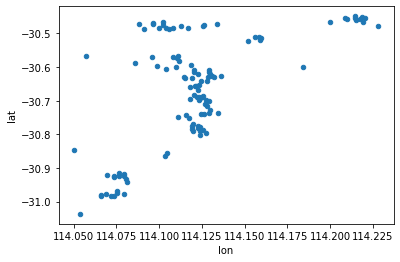

In [ ]:
well_location.plot(kind='scatter', x='lon', y='lat')

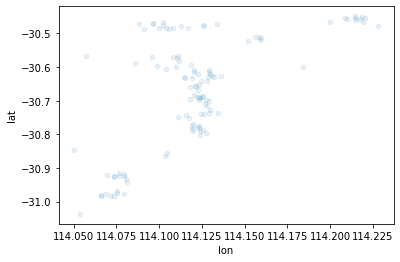

In [ ]:
well_location.plot(kind='scatter', x='lon', y='lat', alpha=0.1)

# Test

In [ ]:
# test_path = path_test = "/content/drive/MyDrive/MLP/Test"
# test_dataset = Load_Data(test_path)

In [ ]:
# Import Blind Data from Google Drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fnNAiJYEI_R2hyeCiRgb6diIfpFB0KG9' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1fnNAiJYEI_R2hyeCiRgb6diIfpFB0KG9" -O blind.csv && rm -rf /tmp/cookies.txt
test_dataset  = pd.read_csv('blind.csv')

In [ ]:
# Know the name and amount of wells in the test dateset 
name_wells_test = Name_Amount(test_dataset)

10


In [ ]:
# Optimize the test dataset
test_dataset = Optimize_df(test_dataset)

In [ ]:
# make a copy of the original dataset
test_dataset_2 = test_dataset.copy()

In [ ]:
test_dataset_2.describe().T

count         mean          std  ...     50%        75%       max
CURRENT     740416.0    34.300754    25.533525  ...    31.0    63.5000    204.30
PRESS_DESC  755094.0  2985.193437  1439.825831  ...  3579.0  3873.3999  14590.80
FREQUENCY   750073.0    45.444832    23.808571  ...    53.0    61.0000    140.00
PRESS_INT   766743.0  1145.752634  1172.052271  ...   420.0  2534.0000  25016.67
TEMP_INT    771497.0   201.205436   109.396505  ...   232.0   235.4000   6553.00
TEMP_MOT    775713.0   242.566017   298.568150  ...   271.0   282.0000   6553.50
VIBRATION   763161.0     0.382106     9.310551  ...     0.0     0.0000    500.00

[7 rows x 8 columns]

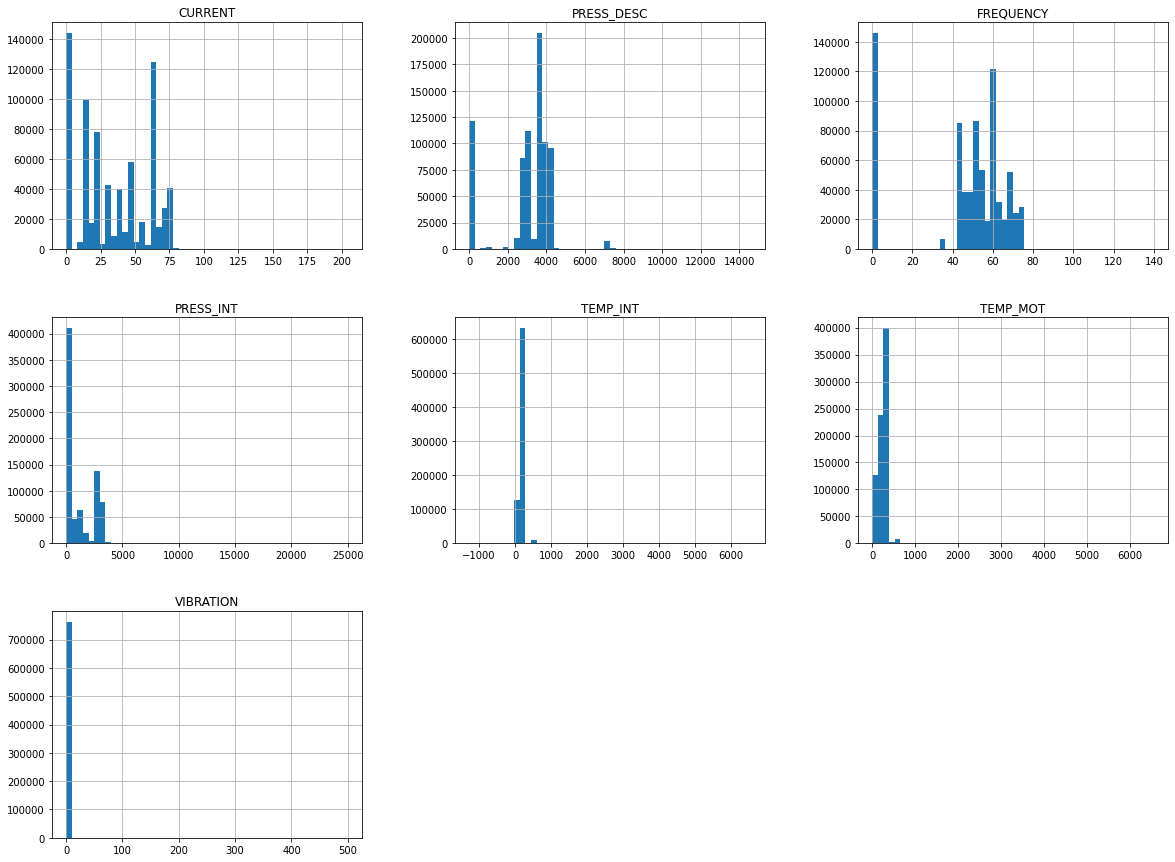

In [ ]:
# View the histogram for each feature of the dataset before handling the outliers
%matplotlib inline
test_dataset_2.hist(bins=50, figsize=(20,15))
plt.show() 

In [ ]:
# Handling outliers
test_dataset_2 = Outliers_Handling(test_dataset_2, name_wells_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(inde

In [ ]:
# View the histogram for each feature of the dataset after handling the outliers
%matplotlib inline
test_dataset_2.hist(bins=50, figsize=(20,15))
plt.show() 

In [ ]:
test_dataset_2.describe().T

count         mean          std  ...     50%     75%          max
CURRENT     740416.0    32.981952    25.865362  ...    31.0    63.5    91.000000
PRESS_DESC  755094.0  2949.022790  1336.706150  ...  3575.0  3646.0  4355.099600
FREQUENCY   750073.0    44.460923    24.124476  ...    52.0    61.0   113.000000
PRESS_INT   766743.0  1130.368656  1136.590553  ...   413.0  2526.0  3471.000000
TEMP_INT    771497.0   198.335798    80.833464  ...   232.5   235.4   256.000000
TEMP_MOT    775713.0   227.668590    95.714273  ...   268.0   278.0   339.000000
VIBRATION   763161.0     0.001592     0.017776  ...     0.0     0.0     0.200136

[7 rows x 8 columns]

In [ ]:
test_missing_data,mask = Missing_Values(test_dataset_2)
test_missing_data

count_missing  perc_missing
WellFailure         786102     99.998728
CURRENT              45696      5.812912
FREQUENCY            36039      4.584461
PRESS_DESC           31018      3.945748
VIBRATION            22951      2.919559
PRESS_INT            19369      2.463898
TEMP_INT             14615      1.859150
TEMP_MOT             10399      1.322839
WELL_ID                  0      0.000000
DATE                     0      0.000000

In [ ]:
nullable_columns = test_dataset_2.columns[mask.any()].tolist()
msno.matrix(test_dataset_2[nullable_columns].sample(500))
plt.show()

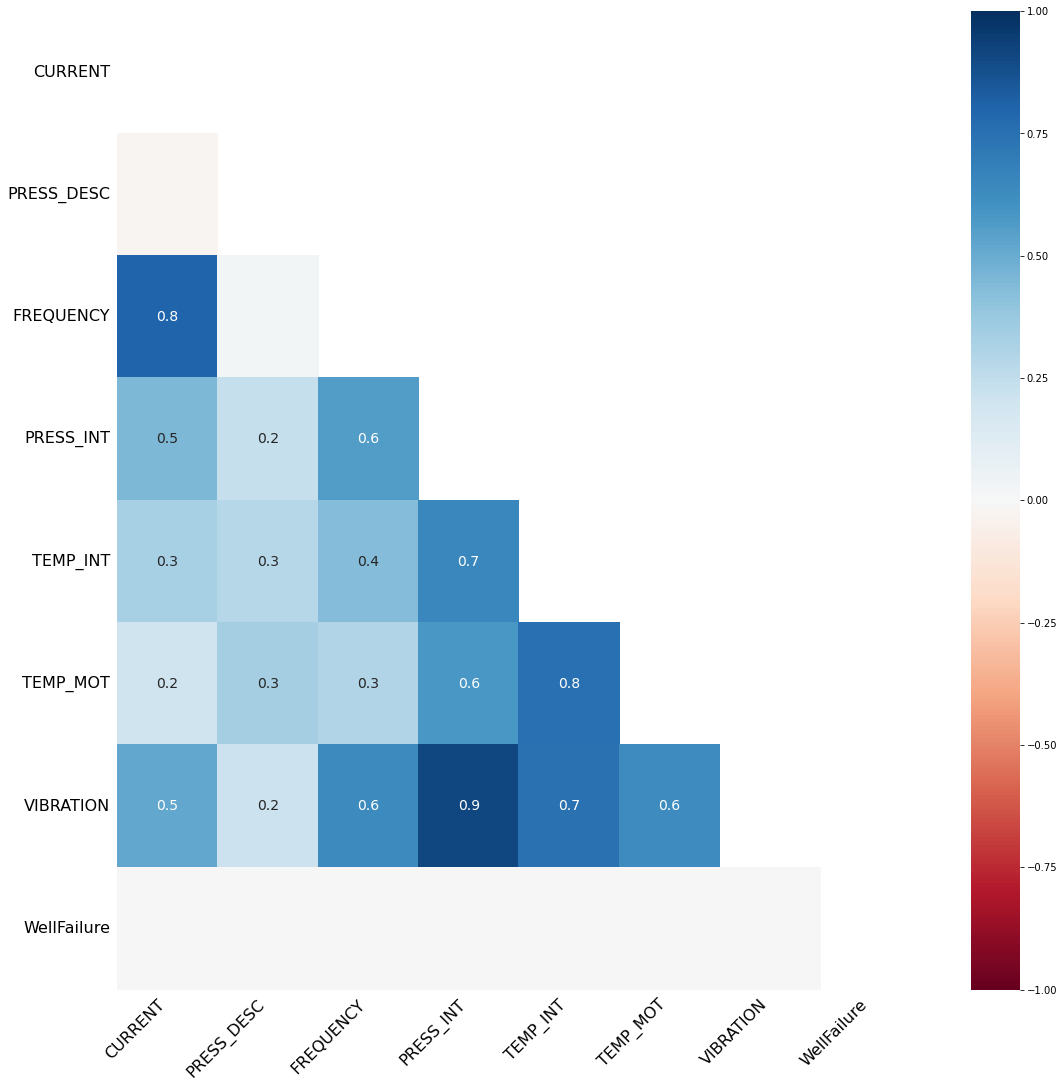

In [ ]:
msno.heatmap(test_dataset_2[nullable_columns], figsize=(18,18))
plt.show()

In [ ]:
# Handling Nans
test_dataset_2 = Handling_Nan(test_dataset_2, name_wells_test)

In [ ]:
test_dataset_2.isna().sum()

WELL_ID             0
DATE                0
CURRENT             0
PRESS_DESC          0
FREQUENCY           0
PRESS_INT           0
TEMP_INT            0
TEMP_MOT            0
VIBRATION           0
WellFailure    786102
dtype: int64

In [ ]:
# First value of a day
test_dataset_2 = First_Value(test_dataset_2, name_wells_test)

In [ ]:
# Scaled of test dataset
test_scaled = []
for well in name_wells_test:
  test_temp_df = test_dataset_2[(test_dataset_2['WELL_ID']==well)]
  col_names_t = [ 'WELL_ID', 'DATE', 'CURRENT', 'PRESS_DESC', 'FREQUENCY', 'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'VIBRATION']
  features = test_temp_df[col_names_t]

  ct = ColumnTransformer([
        ('somename', MinMaxScaler(), ['CURRENT', 'PRESS_DESC', 'FREQUENCY', 'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'VIBRATION'])
    ], remainder='passthrough')
  
  test_scaled_temp = ct.fit_transform(features)
  test_scaled_temp = pd.DataFrame(test_scaled_temp, columns=[ 'CURRENT', 'PRESS_DESC', 'FREQUENCY', 'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'VIBRATION', 'WELL_ID', 'DATE'])

  test_scaled.append(test_scaled_temp)

test_scaled = pd.concat(test_scaled, axis=0, ignore_index=True)
test_scaled.sort_values(by=['WELL_ID','DATE'])


CURRENT PRESS_DESC  ...           WELL_ID                DATE
4405   0.322   0.824622  ...  DEEPWATER-2ZLRT1 2019-02-25 00:00:00
4406   0.384    0.82533  ...  DEEPWATER-2ZLRT1 2019-02-26 00:00:00
4407   0.288   0.824803  ...  DEEPWATER-2ZLRT1 2019-02-27 00:00:00
4408   0.232   0.824741  ...  DEEPWATER-2ZLRT1 2019-02-28 00:00:00
4409   0.204   0.824827  ...  DEEPWATER-2ZLRT1 2019-03-01 00:00:00
...      ...        ...  ...               ...                 ...
2639   0.875          0  ...  DEEPWATER-XWF4WL 2021-05-21 00:18:54
2640   0.875          0  ...  DEEPWATER-XWF4WL 2021-05-22 00:19:05
2641   0.875          0  ...  DEEPWATER-XWF4WL 2021-05-23 00:19:30
2642   0.875          0  ...  DEEPWATER-XWF4WL 2021-05-24 00:19:41
2643   0.875          0  ...  DEEPWATER-XWF4WL 2021-05-25 00:19:20

[5765 rows x 9 columns]

# Model

In [ ]:
#Set DATE as index
train = train_scaled.set_index('DATE')
test = test_scaled.set_index('DATE')

In [ ]:
#Transform object in dataframe to numeric variables
train=train.astype({'CURRENT': 'float64','PRESS_DESC': 'float64','FREQUENCY': 'float64','PRESS_INT': 'float64','TEMP_INT': 'float64','TEMP_MOT': 'float64','VIBRATION': 'float64','FailType': 'int64'})
test=test.astype({'CURRENT': 'float64','PRESS_DESC': 'float64','FREQUENCY': 'float64','PRESS_INT': 'float64','TEMP_INT': 'float64','TEMP_MOT': 'float64','VIBRATION': 'float64'})

In [ ]:
#Set X & Y's
x_train = train.drop(['WELL_ID','FailType','DateDiff'],axis=1)
y_1 = train['FailType']
y_2 = train['DateDiff']
y_train = np.vstack((y_1, y_2)).T

In [ ]:
#Using a Recursive Random Forest Classifier Modelo
forest = RandomForestClassifier(n_estimators=400, max_depth=(400), random_state=1)
selector = RFE(forest, n_features_to_select=10, step=1)
multi_target_forest = MultiOutputClassifier(selector, n_jobs=-1)
print(multi_target_forest.fit(x_train, y_train))

MultiOutputClassifier(estimator=RFE(estimator=RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=400,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     max_samples=None,
                                                                     min_impurity_decrease=0.0,
                                                                     min_impurity_split=None,
                                                                     min_samples_leaf=1,
                          

# Prediction

In [ ]:
x_test = test.drop(['WELL_ID'],axis=1)

In [ ]:
# Prediction
y_pred = multi_target_forest.predict(x_test)
y_pred.shape

(5765, 2)

In [ ]:
# Prediction to frame
y_pred = pd.DataFrame(y_pred, columns=['FailType','DateDiff'])
y_pred

FailType  DateDiff
0            1        -4
1            1        -4
2            1        -4
3            1        -4
4            1        -4
...        ...       ...
5760         1         3
5761         1         3
5762         1         3
5763         1         3
5764         1         3

[5765 rows x 2 columns]

In [ ]:
#Prediction overview
y_pred[(y_pred['DateDiff']==0)&(y_pred['FailType']==2)]
y_pred[(y_pred['DateDiff']==0)]

FailType  DateDiff
24           1         0
25           1         0
26           1         0
27           1         0
38           1         0
...        ...       ...
5750         1         0
5751         1         0
5752         1         0
5753         1         0
5754         1         0

[1659 rows x 2 columns]

# Results

In [ ]:
test = test.reset_index()
test

DATE  CURRENT  ...  VIBRATION           WELL_ID
0    2019-02-25 00:00:00      0.0  ...        0.0  DEEPWATER-O4AWBU
1    2019-02-26 00:00:00      0.0  ...        0.0  DEEPWATER-O4AWBU
2    2019-02-27 00:00:00      0.0  ...        0.0  DEEPWATER-O4AWBU
3    2019-02-28 00:00:00      0.0  ...        0.0  DEEPWATER-O4AWBU
4    2019-03-01 00:00:00      0.0  ...        0.0  DEEPWATER-O4AWBU
...                  ...      ...  ...        ...               ...
5760 2021-05-21 00:00:45      0.2  ...        0.0  DEEPWATER-EHFSV4
5761 2021-05-22 00:00:03      0.2  ...        0.0  DEEPWATER-EHFSV4
5762 2021-05-23 00:00:49      0.2  ...        0.0  DEEPWATER-EHFSV4
5763 2021-05-24 00:00:55      0.2  ...        0.0  DEEPWATER-EHFSV4
5764 2021-05-25 00:00:46      0.2  ...        0.0  DEEPWATER-EHFSV4

[5765 rows x 9 columns]

In [ ]:
result = test.join(y_pred)
result

DATE  CURRENT  ...  FailType  DateDiff
0    2019-02-25 00:00:00      0.0  ...         1        -4
1    2019-02-26 00:00:00      0.0  ...         1        -4
2    2019-02-27 00:00:00      0.0  ...         1        -4
3    2019-02-28 00:00:00      0.0  ...         1        -4
4    2019-03-01 00:00:00      0.0  ...         1        -4
...                  ...      ...  ...       ...       ...
5760 2021-05-21 00:00:45      0.2  ...         1         3
5761 2021-05-22 00:00:03      0.2  ...         1         3
5762 2021-05-23 00:00:49      0.2  ...         1         3
5763 2021-05-24 00:00:55      0.2  ...         1         3
5764 2021-05-25 00:00:46      0.2  ...         1         3

[5765 rows x 11 columns]

In [ ]:
result = result.sort_values(by=['WELL_ID', 'DATE'])
result

DATE  CURRENT  ...  FailType  DateDiff
4405 2019-02-25 00:00:00    0.322  ...         1        -3
4406 2019-02-26 00:00:00    0.384  ...         1        -3
4407 2019-02-27 00:00:00    0.288  ...         1        -3
4408 2019-02-28 00:00:00    0.232  ...         1        -3
4409 2019-03-01 00:00:00    0.204  ...         1        -3
...                  ...      ...  ...       ...       ...
2639 2021-05-21 00:18:54    0.875  ...         1         0
2640 2021-05-22 00:19:05    0.875  ...         1         0
2641 2021-05-23 00:19:30    0.875  ...         1         0
2642 2021-05-24 00:19:41    0.875  ...         1         0
2643 2021-05-25 00:19:20    0.875  ...         1         0

[5765 rows x 11 columns]

In [ ]:
result[(result['DateDiff']==1)&(result['FailType']==1)]

DATE  CURRENT  ...  FailType  DateDiff
4460 2019-05-21 00:00:00    0.720  ...         1         1
4530 2019-08-04 00:00:00    0.998  ...         1         1
4540 2019-08-14 00:00:00    1.000  ...         1         1
4541 2019-08-15 00:00:00    1.000  ...         1         1
4544 2019-08-18 00:00:00    1.000  ...         1         1
...                  ...      ...  ...       ...       ...
2483 2020-11-13 00:19:03    0.625  ...         1         1
2484 2020-11-14 00:19:39    0.625  ...         1         1
2486 2020-11-16 00:19:16    0.625  ...         1         1
2489 2020-11-19 00:18:51    0.625  ...         1         1
2491 2020-11-21 00:19:46    0.625  ...         1         1

[938 rows x 11 columns]

In [ ]:
result['DATE']=result['DATE'].apply(pd.to_datetime)

In [ ]:
name_wells_test

array(['DEEPWATER-O4AWBU', 'DEEPWATER-HTRCRO', 'DEEPWATER-3XFTSJ',
       'DEEPWATER-QVFBDM', 'DEEPWATER-XWF4WL', 'DEEPWATER-LIS23E',
       'DEEPWATER-OUFAML', 'DEEPWATER-M3XG2L', 'DEEPWATER-2ZLRT1',
       'DEEPWATER-EHFSV4'], dtype=object)

In [ ]:
result[(result['WELL_ID']==name_wells_test[0])&(result['DateDiff']==0)]

DATE  CURRENT  ...  FailType  DateDiff
24  2019-03-21 00:00:00      0.0  ...         1         0
25  2019-03-22 00:00:00      0.0  ...         1         0
26  2019-03-23 00:00:00      0.0  ...         1         0
27  2019-03-24 00:00:00      0.0  ...         1         0
38  2019-04-04 00:00:00      0.0  ...         1         0
..                  ...      ...  ...       ...       ...
548 2021-03-08 15:59:08      0.0  ...         1         0
549 2021-03-09 00:19:47      0.0  ...         1         0
550 2021-03-11 07:18:52      0.0  ...         1         0
551 2021-03-12 19:18:51      0.0  ...         1         0
552 2021-03-13 00:19:55      0.0  ...         1         0

[170 rows x 11 columns]

In [ ]:
result = Results(result, name_wells_test)
result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

WELL_ID                DATE  FailType
0  DEEPWATER-O4AWBU 2019-03-21 00:00:00         1
1  DEEPWATER-HTRCRO 2019-12-09 00:00:00         1
2  DEEPWATER-3XFTSJ 2020-12-16 00:19:43         1
3  DEEPWATER-QVFBDM 2020-06-05 00:04:37         1
4  DEEPWATER-XWF4WL 2021-02-01 00:18:54         1
5  DEEPWATER-LIS23E 2019-04-17 00:00:00         1
6  DEEPWATER-OUFAML 2019-08-03 00:00:00         1
7  DEEPWATER-M3XG2L 2021-05-13 00:14:03         1
8  DEEPWATER-2ZLRT1 2019-04-07 00:00:00         1
9  DEEPWATER-EHFSV4 2020-04-09 00:00:00         1

In [ ]:
result.rename(columns={'FailType': 'WellFailure'}, inplace=True)
result

WELL_ID                DATE  WellFailure
0  DEEPWATER-O4AWBU 2019-03-21 00:00:00            1
1  DEEPWATER-HTRCRO 2019-12-09 00:00:00            1
2  DEEPWATER-3XFTSJ 2020-12-16 00:19:43            1
3  DEEPWATER-QVFBDM 2020-06-05 00:04:37            1
4  DEEPWATER-XWF4WL 2021-02-01 00:18:54            1
5  DEEPWATER-LIS23E 2019-04-17 00:00:00            1
6  DEEPWATER-OUFAML 2019-08-03 00:00:00            1
7  DEEPWATER-M3XG2L 2021-05-13 00:14:03            1
8  DEEPWATER-2ZLRT1 2019-04-07 00:00:00            1
9  DEEPWATER-EHFSV4 2020-04-09 00:00:00            1

In [ ]:
# Assing a failure type ---> 1=yes : 2=Manual off
result.loc[result.WellFailure==1,'WellFailure']='yes'
result.loc[result.WellFailure==2,'WellFailure']='Manual off'
result

WELL_ID                DATE WellFailure
0  DEEPWATER-O4AWBU 2019-03-21 00:00:00         yes
1  DEEPWATER-HTRCRO 2019-12-09 00:00:00         yes
2  DEEPWATER-3XFTSJ 2020-12-16 00:19:43         yes
3  DEEPWATER-QVFBDM 2020-06-05 00:04:37         yes
4  DEEPWATER-XWF4WL 2021-02-01 00:18:54         yes
5  DEEPWATER-LIS23E 2019-04-17 00:00:00         yes
6  DEEPWATER-OUFAML 2019-08-03 00:00:00         yes
7  DEEPWATER-M3XG2L 2021-05-13 00:14:03         yes
8  DEEPWATER-2ZLRT1 2019-04-07 00:00:00         yes
9  DEEPWATER-EHFSV4 2020-04-09 00:00:00         yes

#<b> Blind Scoring

In [ ]:
from sklearn.metrics import accuracy_score
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yqJnu5Liti62EAWoem5wee472biMrTEf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1yqJnu5Liti62EAWoem5wee472biMrTEf" -O blind_result.csv && rm -rf /tmp/cookies.txt

In [ ]:
blind_result = pd.read_csv('blind_result.csv',parse_dates=[1])
blind_result 

WELL_ID                DATE WellFailure
0  DEEPWATER-O4AWBU 2020-08-23 00:00:03         yes
1  DEEPWATER-3XFTSJ 2020-12-15 00:19:05         yes
2  DEEPWATER-QVFBDM 2020-06-07 00:04:37         yes
3  DEEPWATER-XWF4WL 2021-04-12 00:18:57         yes
4  DEEPWATER-LIS23E 2020-04-02 00:00:00         yes
5  DEEPWATER-OUFAML 2021-04-01 00:01:30         yes
6  DEEPWATER-M3XG2L 2020-02-28 00:00:00         yes
7  DEEPWATER-2ZLRT1 2020-08-13 00:19:02         yes
8  DEEPWATER-EHFSV4 2021-05-01 00:01:51         yes

In [ ]:
result = result.drop(1).reset_index().drop('index',1)
result 

WELL_ID                DATE WellFailure
0  DEEPWATER-O4AWBU 2019-03-21 00:00:00         yes
1  DEEPWATER-3XFTSJ 2020-12-16 00:19:43         yes
2  DEEPWATER-QVFBDM 2020-06-05 00:04:37         yes
3  DEEPWATER-XWF4WL 2021-02-01 00:18:54         yes
4  DEEPWATER-LIS23E 2019-04-17 00:00:00         yes
5  DEEPWATER-OUFAML 2019-08-03 00:00:00         yes
6  DEEPWATER-M3XG2L 2021-05-13 00:14:03         yes
7  DEEPWATER-2ZLRT1 2019-04-07 00:00:00         yes
8  DEEPWATER-EHFSV4 2020-04-09 00:00:00         yes

In [ ]:
truth = blind_result.copy()
pred = result.copy()

if pred.isnull().sum().sum() == 0:

####################################################################################

    if (truth['WELL_ID'] == pred['WELL_ID']).all() and len(np.union1d(truth.keys(),pred.keys()))==3:
        score = pd.merge(truth,pred,on=['WELL_ID'],suffixes=('_true','_pred'),how='left')
        
        ############################ GRADE DATE PREDICTION #####################################
        date_scores = []

        for i in score.index:
            
            timedelta = (pd.Timestamp(score.iloc[i,1]) - pd.Timestamp(score.iloc[i,3])).days
            if timedelta < 0:
                timedelta = (pd.Timestamp(score.iloc[i,3]) - pd.Timestamp(score.iloc[i,1])).days
                
            if timedelta == 0:
                date_scores.append(1)        
            elif timedelta == 1:
                date_scores.append(0.9) 
            elif timedelta == 2:
                date_scores.append(0.8)  
            elif timedelta == 3:
                date_scores.append(0.7)
            elif timedelta == 4:
                date_scores.append(0.6)
            elif timedelta == 5:
                date_scores.append(0.5)
            elif timedelta == 6:
                date_scores.append(0.4)   
            elif timedelta == 7:
                date_scores.append(0.3)                                                                
            elif timedelta == 8:
                date_scores.append(0.2)   
            elif timedelta <30:
                date_scores.append(-1)         
            else:
                date_scores.append(-3)

        date_score = np.sum(date_scores)/len(truth)

        ################################### GRADE ACCURACY PREDICTION ##########################
        failure_score = accuracy_score(score['WellFailure_true'].values,score['WellFailure_pred'].values)
        
        ##################################### FINAL SCORE ######################################
        
        final_score = round(date_score*failure_score,3)

    else:
        final_score = -999

final_score

-2.144

<h1><b> Final Score: 
<h2><b> -2.144
<h3> Tested by Felix Gallo
<h3> E-Challenge Team
<h3><B> SPE Ecuador Section

In [ ]:
# Write the prediction to a zip file
result.to_csv('predictions.csv',index=False)
zipfile.ZipFile('predictions.zip', mode='w').write("predictions.csv")